Use the Gerstner's model and triplet net to reproduce the timing dependent curve.

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [3]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0


array([ 0.00987208,  0.00346529,  2.15974808])

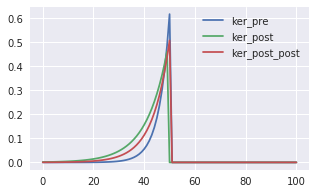

In [4]:
# Generate the kernel
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
ker_test = KernelGen(len_kernel=101)
ker_test.trip_model_ker(para, data_name='Hippocampus')
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))
ker_test.kernel_scale

[-110, 100, -30, 60]

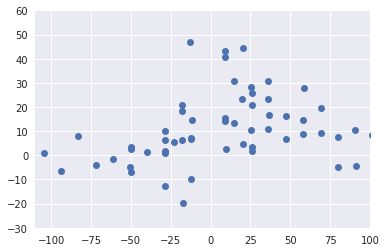

In [5]:
# Generate the target spike traine
data3 = data[data['ptl_idx']==3]
X = np.array(data3['dt2']).reshape(-1,1)
y = np.array(data3['dw_mean']).reshape(-1,1)
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.axis([-110, 100, -30, 60])

In [6]:
# Generate dt1
# Insert values for Quadruplet
dt = np.concatenate([np.arange(-100,-10,2).reshape(-1,1), np.arange(10,100,2).reshape(-1,1)])
data3_gen = pd.DataFrame(data=None, columns=list(data.columns))
for i in range(len(dt)):
    new_try3 = data3.iloc[0]
    new_try3['dt2'] = dt[i]
    data3_gen = data3_gen.append(new_try3, ignore_index=True)

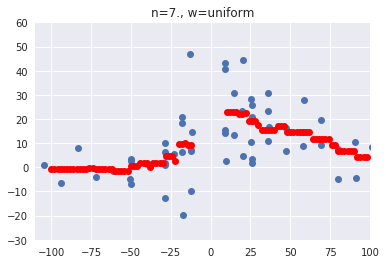

In [7]:
from sklearn.neighbors import KNeighborsRegressor

# Choose one parameter and generate the prediction
n_neighbors = 7
weights = 'uniform'

Kn_reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
Kn_reg.fit(X,y)
y_pred = Kn_reg.predict(np.array(data3_gen['dt2']).reshape(-1,1))
targets3=y_pred
plt.plot(data3['dt2'], data3['dw_mean'], 'o')
plt.plot(data3_gen['dt2'], y_pred, 'ro')
plt.axis([-110,100,-30,60])
plt.title('.'.join(('n=%d'%(n_neighbors), ', w=%s'%(weights))))

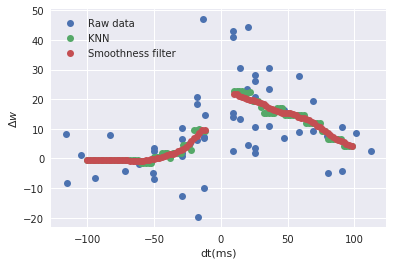

In [8]:
width_list = np.concatenate([np.linspace(10,3,45), np.linspace(3,10,45)])
targets3_sm = np.concatenate([dw_gen.smooth(targets3[:45],width_list = width_list), dw_gen.smooth(targets3[45:],width_list = width_list)])
plt.plot(data3['dt2'], data3['dw_mean'], 'o', label='Raw data')
plt.plot(data3_gen['dt2'], targets3,'o', label='KNN')
plt.plot(data3_gen['dt2'], targets3_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend()

In [33]:
# Generate targets using specific kernel
ptl_list = [3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data3_gen, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[20], net_type='triplet', seed=1)

In [34]:
dt2=[]
test = spk_pairs
for i in range(test.shape[0]):
    test_pre = np.where(test[i][:,0]==1)[0]
    test_post = np.where(test[i][:, 1]==1)[0]
    if test_pre[0] < test_post[0]:   # Pre-post-post-pre
        idx = np.arange(0,len(test_post),2)
        test_post_1 = test_post[idx]
        test_post_2 = test_post[idx+1]
        dt2.append(np.mean(test_post_1-test_post_2))
    else:   # Post-pre-pre-post
        idx = np.arange(0,len(test_pre),2)
        test_pre_1 = test_pre[idx]
        test_pre_2 = test_pre[idx+1]
        dt2.append(np.mean(test_pre_2-test_pre_1))

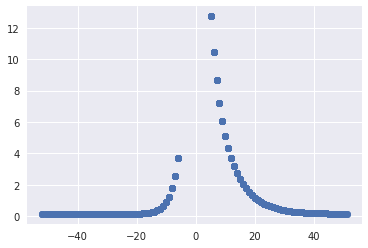

In [35]:
# Visualize the dt result
plt.plot(dt2, targets, 'o')

In [12]:
# Visualize the trace with |dt2|=6

idx_neg = np.where(np.array(dt2) == -6)[0][0]
idx_posi = np.where(np.array(dt2) == 6)[0][0]

In [13]:
spk_neg = spk_pairs[idx_neg, :, : ].reshape((-1,30000,2))
spk_posi = spk_pairs[idx_posi, :, : ].reshape((-1,30000,2))

In [14]:
spk_neg.shape

(1, 30000, 2)

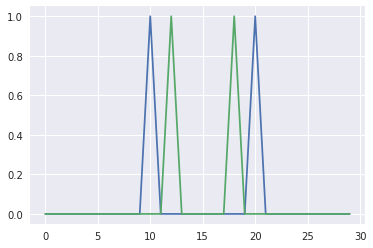

In [15]:
plt.plot(spk_neg[0,250:280,0])
plt.plot(spk_neg[0,250:280,1])

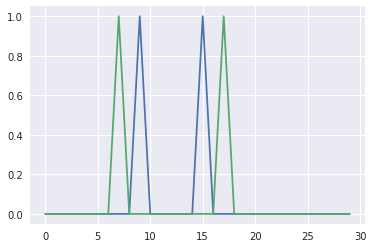

In [16]:
plt.plot(spk_posi[0, 320:350,0])
plt.plot(spk_posi[0, 320:350,1])

In [25]:
# Convolve spike trains with kernels
def spk_cov(spk):
    tf.reset_default_graph()

    with tf.Graph().as_default():
        x = tf.placeholder(dtype=tf.float32, shape=[None, 30000, 2], name='x')
        x_pre, x_post = tf.unstack(x, axis=2)
        x_post_post = tf.concat([x_post[:, 1:], tf.expand_dims(x_post[:,0], axis=1)], axis=1)

        ker_pre = tf.get_variable(name='ker_pre', shape=ker_test.kernel_pre.shape, dtype=tf.float32, initializer=tf.constant_initializer(ker_test.kernel_pre))
        ker_post = tf.get_variable(name='ker_post', shape=ker_test.kernel_post.shape, dtype=tf.float32, initializer=tf.constant_initializer(ker_test.kernel_post))
        ker_post_post = tf.get_variable(name='ker_post_post', shape=ker_test.kernel_post_post.shape, dtype=tf.float32, initializer=tf.constant_initializer(ker_test.kernel_post_post))
        fc = tf.get_variable(name='fc', shape=ker_test.kernel_scale.shape, dtype=tf.float32, initializer=tf.constant_initializer(ker_test.kernel_scale))
        
        y_pre = y = tf.nn.conv1d(value=tf.expand_dims(x_pre, axis=2), filters=tf.expand_dims(ker_pre, axis=2), stride=1, padding='SAME')
        y_post = y = tf.nn.conv1d(value=tf.expand_dims(x_post, axis=2), filters=tf.expand_dims(ker_post, axis=2), stride=1, padding='SAME')
        y_post_post = y = tf.nn.conv1d(value=tf.expand_dims(x_post, axis=2), filters=tf.expand_dims(ker_post_post, axis=2), stride=1, padding='SAME')

        pair_term1 = tf.reduce_mean(tf.multiply(y_pre, tf.expand_dims(x_post, axis=2)), axis=1)
        pair_term2 = tf.reduce_mean(tf.multiply(y_post, tf.expand_dims(x_pre, axis=2)), axis=1)
        trip_term = tf.reduce_mean(tf.multiply(tf.multiply(y_pre, y_post_post), tf.expand_dims(x_post_post, axis=2)), axis=1)
        
        terms = tf.concat([pair_term1, -1 * pair_term2, trip_term], axis=1)
        
        prediction = tf.matmul(terms, tf.expand_dims(fc, axis=1))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            y_pre_output = sess.run(y_pre, feed_dict={x:spk})
            y_post_output = sess.run(y_post, feed_dict={x:spk})
            y_post_post_output = sess.run(y_post_post, feed_dict={x:spk})
            
            pair_term1_out,pair_term2_out,trip_term_out, prediction = sess.run([pair_term1,pair_term2,trip_term, prediction], feed_dict={x:spk})
            
            
    return y_pre_output, y_post_output, y_post_post_output, pair_term1_out,pair_term2_out,trip_term_out, prediction

In [26]:
y_pre_neg, y_post_neg, y_post_post_neg, pair_term1_neg,pair_term2_neg,trip_term_neg, prediction_neg = spk_cov(spk_neg)
y_pre_posi, y_post_posi, y_post_post_posi, pair_term1_posi,pair_term2_posi, trip_term_posi, prediction_posi = spk_cov(spk_posi)

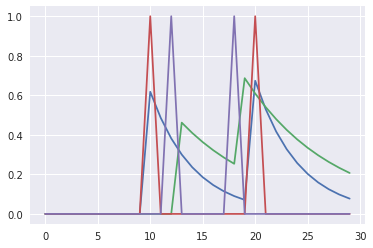

In [27]:
plt.plot(y_pre_neg[0,250:280,0])
plt.plot(y_post_neg[0,250:280,0])
plt.plot(spk_neg[0,250:280,0])
plt.plot(spk_neg[0,250:280,1])

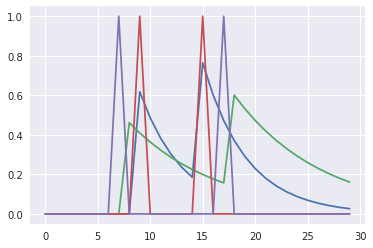

In [28]:
plt.plot(y_pre_posi[0,320:350,0])
plt.plot(y_post_posi[0,320:350,0])
plt.plot(spk_posi[0, 320:350,0])
plt.plot(spk_posi[0, 320:350,1])

In [31]:
pair_term1_neg,pair_term2_neg,trip_term_neg, prediction_neg

(array([[ 0.00094446]], dtype=float32),
 array([[ 0.00121811]], dtype=float32),
 array([[  5.52476813e-05]], dtype=float32),
 array([[ 0.00012442]], dtype=float32))

In [32]:
pair_term1_posi,pair_term2_posi,trip_term_posi, prediction_posi

(array([[ 0.00094446]], dtype=float32),
 array([[ 0.00121811]], dtype=float32),
 array([[ 0.0001589]], dtype=float32),
 array([[ 0.00034828]], dtype=float32))

In [ ]:
ker_test.kernel_scale